In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fixed The Images

Fixed the images first to make the plate more readable, and I will compare original image with processed images

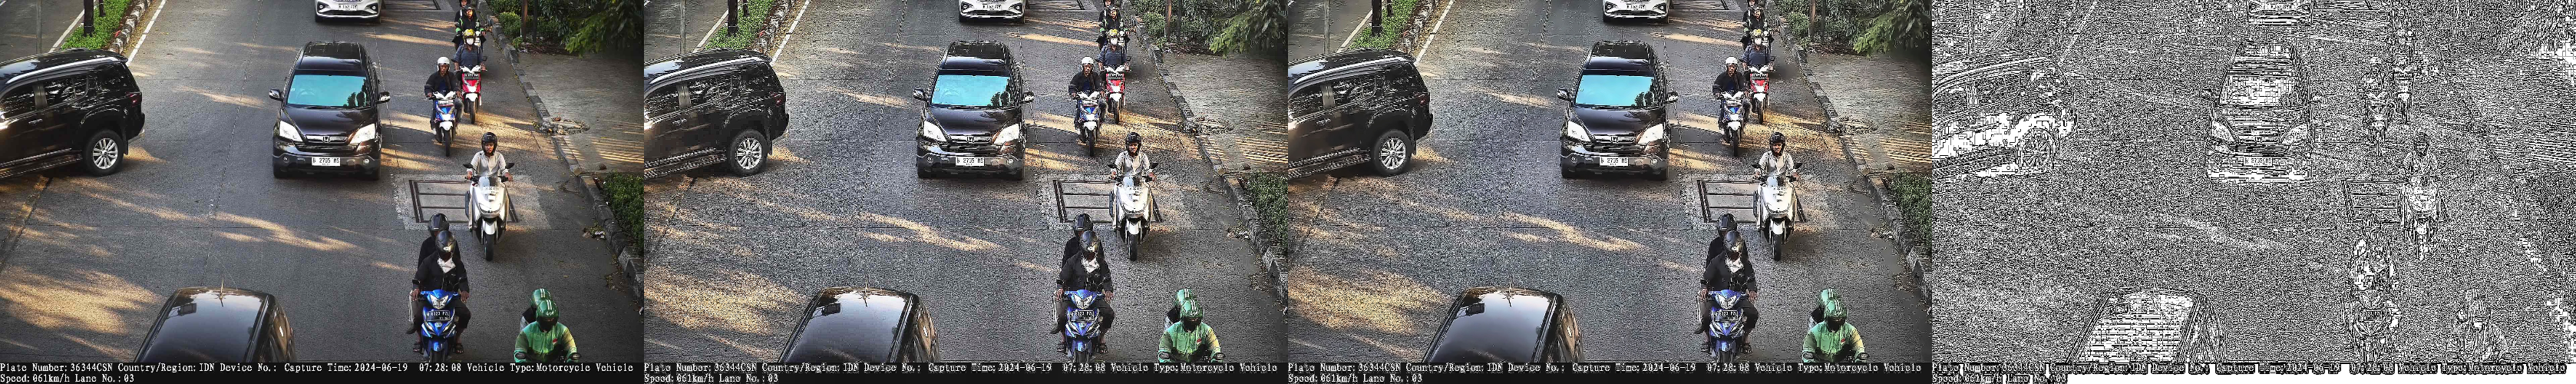

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Jika di Google Colab

# Fungsi untuk membaca gambar
def read_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Gambar {image_path} tidak ditemukan.")
    return image

# Path gambar
image_paths = [
    '/content/drive/MyDrive/Comvi/ANPR/Traffic/2.TL.Jembatan Merah/11.jpg',
    '/content/drive/MyDrive/gambar.jpg',
    '/content/drive/MyDrive/gambar_denoised.jpg',
    '/content/drive/MyDrive/gambar_thresholded.jpg'
]

# Baca gambar
images = [read_image(path) for path in image_paths]

# Pastikan semua gambar memiliki ukuran yang sama
height = 500  # Tinggi yang diinginkan untuk semua gambar
resized_images = [cv2.resize(img, (int(img.shape[1] * height / img.shape[0]), height)) for img in images]

# Gabungkan gambar secara horizontal
result = np.hstack(resized_images)

# Tampilkan hasil
cv2_imshow(result)  # Untuk Google Colab
# cv2.imshow("Hasil Gabungan", result)  # Gunakan ini jika di desktop
# cv2.waitKey(0)
# cv2.destroyAllWindows()


## Add Sharpening, Increase the contrasts, and add denoising

In [ ]:
import cv2
import os
import numpy as np

# Fungsi untuk memproses gambar
def process_image(image_path):
    # Baca gambar
    image = cv2.imread(image_path)

    # Tingkatkan ketajaman
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)

    # Tingkatkan kontras
    lab = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Terapkan denoising
    denoised_image = cv2.fastNlMeansDenoisingColored(enhanced_image, None, 10, 10, 7, 21)

    return denoised_image

# Path folder input dan output
input_folder = '/content/drive/MyDrive/Comvi/ANPR/Traffic'
output_folder = '/content/drive/MyDrive/Comvi/ANPR/Fixed Images'

# Loop melalui folder dan subfolder
for root, dirs, files in os.walk(input_folder):
    skip_subfolder = False  # Flag untuk melewati subfolder jika file sudah ada
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter gambar
            input_path = os.path.join(root, file)

            # Buat path output yang sama dengan input
            relative_path = os.path.relpath(root, input_folder)
            output_path = os.path.join(output_folder, relative_path)
            os.makedirs(output_path, exist_ok=True)  # Buat folder jika belum ada

            # Path file output
            output_file_path = os.path.join(output_path, file)

            # Cek apakah file sudah ada di folder output
            if os.path.exists(output_file_path):
                print(f"File '{output_file_path}' sudah ada. Melewati subfolder '{relative_path}'.")
                skip_subfolder = True  # Set flag untuk melewati subfolder
                break  # Keluar dari loop file untuk subfolder ini

    if skip_subfolder:
        continue  # Langsung ke subfolder berikutnya jika flag diaktifkan

    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter gambar
            input_path = os.path.join(root, file)

            # Buat path output yang sama dengan input
            relative_path = os.path.relpath(root, input_folder)
            output_path = os.path.join(output_folder, relative_path)
            os.makedirs(output_path, exist_ok=True)  # Buat folder jika belum ada

            # Proses gambar
            processed_image = process_image(input_path)

            # Simpan hasil dengan nama file yang sama
            output_file_path = os.path.join(output_path, file)
            cv2.imwrite(output_file_path, processed_image)

print("Proses selesai! Gambar disimpan di folder 'Fixed Images'.")

Proses selesai! Gambar disimpan di folder 'Fixed Images'.


## Result of the processed Images

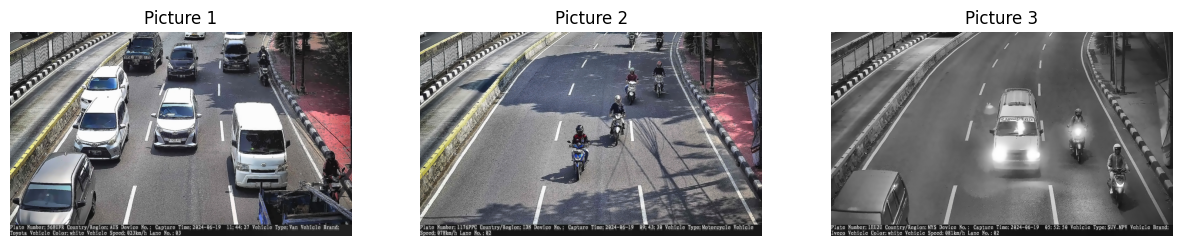

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Path ke gambar
picture_1 = "/content/drive/MyDrive/Comvi/ANPR/Fixed Images/3.TL.Kartini/1.jpg"
picture_2 = "/content/drive/MyDrive/Comvi/ANPR/Fixed Images/3.TL.Kartini/2.jpg"
picture_3 = "/content/drive/MyDrive/Comvi/ANPR/Fixed Images/3.TL.Kartini/3.jpg"

# Membaca gambar
images = [Image.open(picture) for picture in [picture_1, picture_2, picture_3]]

# Menampilkan gambar
plt.figure(figsize=(15, 5))
for i, img in enumerate(images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Picture {i + 1}")
plt.show()

From the picture we know that the results from the process doesnt change anything rather than make it worse

# Crop the vehicles

We need to import model we need to crop the vehicles on every images to specified the picture, we need this process to use super resolution to make every vehicle look clearer

In [ ]:
# Instalasi Ultralytics YOLO
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 23.5 MB/s eta 0:00:00


In [ ]:
# Impor YOLO
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Muat model YOLOv8
model = YOLO('yolov8n.pt')  # Anda bisa mengganti dengan 'yolov8s.pt' atau model lain jika diperlukan

100%|██████████| 6.25M/6.25M [00:00<00:00, 115MB/s]


In [ ]:
import os
import shutil
import numpy as np

# Fungsi utama untuk mendeteksi, memotong, dan menyimpan kendaraan
def detect_crop_and_save(input_folder, output_folder):
    # Loop melalui semua subfolder dan file di folder input
    for root, dirs, files in os.walk(input_folder):
        vehicle_count = 0  # Penghitung kendaraan untuk setiap subfolder
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter file gambar
                input_path = os.path.join(root, file)

                # Membaca gambar
                image = cv2.imread(input_path)
                if image is None:
                    print(f"Gagal membaca gambar: {input_path}")
                    continue

                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Jalankan deteksi kendaraan
                results = model.predict(image_rgb)

                # Ambil path relatif untuk output subfolder
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                os.makedirs(output_subfolder, exist_ok=True)  # Buat folder jika belum ada

                # Variabel untuk melacak duplikasi
                vehicle_counter = {}

                # Proses setiap kendaraan yang terdeteksi
                for result in results[0].boxes:
                    # Ambil bounding box, confidence, dan ID kelas
                    bbox = result.xyxy[0].cpu().numpy()
                    class_id = int(result.cls[0].cpu().numpy())
                    confidence = result.conf[0].cpu().numpy()
                    class_name = model.names[class_id]

                    # Hanya proses kendaraan tertentu
                    if class_name in ['car', 'motorcycle', 'bus', 'truck']:
                        x_min, y_min, x_max, y_max = map(int, bbox)

                        # Lakukan crop gambar
                        crop_img = image[y_min:y_max, x_min:x_max]

                        # Penamaan file dengan pengecekan duplikat
                        base_name = f"{os.path.splitext(file)[0]}-{class_name}"
                        if base_name not in vehicle_counter:
                            vehicle_counter[base_name] = 1
                        else:
                            vehicle_counter[base_name] += 1

                        new_file_name = f"{base_name}({vehicle_counter[base_name]}).jpg" if vehicle_counter[base_name] > 1 else f"{base_name}.jpg"
                        output_file_path = os.path.join(output_subfolder, new_file_name)

                        # Simpan potongan gambar
                        cv2.imwrite(output_file_path, crop_img)
                        print(f"Disimpan: {output_file_path}")

                        # Tambahkan ke penghitung kendaraan
                        vehicle_count += 1

        # Tampilkan jumlah kendaraan yang terdeteksi di subfolder
        relative_path = os.path.relpath(root, input_folder)
        print(f"Jumlah kendaraan yang terdeteksi di folder '{relative_path}': {vehicle_count}")


# Path folder input dan output
input_folder = '/content/drive/MyDrive/Comvi/ANPR/Traffic'
output_folder = '/content/drive/MyDrive/Comvi/ANPR/Cropped Vehicles'

# Jalankan fungsi utama
detect_crop_and_save(input_folder, output_folder)

In [ ]:
import os

# Define the path
path = "/content/drive/MyDrive/Comvi/ANPR/Cropped Vehicles"

# Loop through each subfolder and count files
for root, dirs, files in os.walk(path):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"Folder: {dir_name}, Jumlah file: {file_count}")


Folder: 48. TL.PERINTIS KELAPA GADING, Jumlah file: 649
Folder: 36. TL.RS FATMAWATI, Jumlah file: 986
Folder: 47. TL.CD RADEN INTEN, Jumlah file: 439
Folder: 32. TL. CENGKARENG, Jumlah file: 912
Folder: 38. TL.DUREN TIGA, Jumlah file: 952
Folder: 30. TL.PLUIT JUNCTION, Jumlah file: 829
Folder: 13.TL.Cawang UKI, Jumlah file: 491
Folder: 12. TL.TRIKORA, Jumlah file: 998
Folder: 19.TL.Jembatan 2, Jumlah file: 867
Folder: 11. TL.RAWAMANGUN GOLF, Jumlah file: 453
Folder: 9.TL.H.Ten, Jumlah file: 658
Folder: 37. TL.MAKAM KALIBATA, Jumlah file: 725
Folder: 49. TL.ENGGANO, Jumlah file: 0
Folder: 31. TL.Jembatan 3, Jumlah file: 578
Folder: 33. TL.AMIR HAMZAH, Jumlah file: 904
Folder: 10. TL.PRAMUKA, Jumlah file: 278
Folder: 17.TL.Tomang, Jumlah file: 488
Folder: 34. TL.POS PENGUMBEN, Jumlah file: 672
Folder: 20.TL.Jembatan 5, Jumlah file: 786
Folder: 35.TL.KARTINI PONDOK INDAH, Jumlah file: 574
Folder: 3.TL.Kartini, Jumlah file: 805
Folder: 8.TL.Coca Cola, Jumlah file: 603
Folder: 6.TL.Wahidin,

# Super Resolution

I use Real-ESRGAN for the super resolution, and you can use it just by clone repositories and install torchvision==0.16.0

In [ ]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py developt

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 757 (from 2)
Receiving objects: 100% (759/759), 5.39 MiB | 20.97 MiB/s, done.
Resolving deltas: 100% (406/406), done.
/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 21.9 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=822e62a1dc63f6af0bf3529559e7cb2774341b8f6c9e5c6dd365d88da0ec6ace
  Stored in directory: /root/.cache/pip/whe

In [ ]:
!pip install torchvision==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

In [ ]:
import os
import shutil

# Path sumber dan tujuan
source_folder = '/content/drive/MyDrive/Comvi/ANPR/Cropped Vehicles'
destination_folder = '/content/Real-ESRGAN/upload'

# Pastikan folder tujuan ada, jika tidak, buat folder tersebut
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Salin semua file dan subfolder
for root, dirs, files in os.walk(source_folder):
    for dir_name in dirs:
        # Buat struktur subfolder di tujuan
        src_dir = os.path.join(root, dir_name)
        relative_path = os.path.relpath(src_dir, source_folder)
        dest_dir = os.path.join(destination_folder, relative_path)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

    for file_name in files:
        # Salin file ke tujuan sesuai dengan struktur subfolder
        src_file = os.path.join(root, file_name)
        relative_path = os.path.relpath(src_file, source_folder)
        dest_file = os.path.join(destination_folder, relative_path)
        shutil.copy2(src_file, dest_file)

print("Copying completed successfully!")

In [ ]:
import os
import shutil

# Path asal dan tujuan
source_folder = '/content/drive/MyDrive/Comvi/ANPR/Cropped Vehicles/2.TL.Jembatan Merah'
upload_folder = '/content/Real-ESRGAN/upload'

# Hapus isi folder upload jika ada
if os.path.exists(upload_folder):
    shutil.rmtree(upload_folder)

# Buat folder upload
os.makedirs(upload_folder)

# Pindahkan semua file dari source_folder ke upload_folder
for item in os.listdir(source_folder):
    full_item_path = os.path.join(source_folder, item)
    if os.path.isfile(full_item_path):
        shutil.copy2(full_item_path, upload_folder)

print(f"File dari {source_folder} telah dipindahkan ke {upload_folder}.")


File dari /content/drive/MyDrive/Comvi/ANPR/Cropped Vehicles/2.TL.Jembatan Merah telah dipindahkan ke /content/Real-ESRGAN/upload.


In [ ]:
# if it is out of memory, try to use the `--tile` option
# We upsample the image with the scale factor X3.5
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore.

python3: can't open file '/content/inference_realesrgan.py': [Errno 2] No such file or directory


In [ ]:
import os
import shutil

# Paths
results_folder = '/content/Real-ESRGAN/results'
destination_folder = '/content/drive/MyDrive/Comvi/ANPR/Clear Images/8.TL.Coca Cola'

# Pindahkan folder results
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

shutil.move(results_folder, destination_folder)

print(f"Folder {results_folder} telah dipindahkan ke {destination_folder}.")


Folder /content/Real-ESRGAN/results telah dipindahkan ke /content/drive/MyDrive/Comvi/ANPR/Clear Images/8.TL.Coca Cola.


In [ ]:
import os
import shutil

# Path asal dan tujuan
source_base_folder = '/content/drive/MyDrive/Comvi/ANPR/Cropped Vehicles/'
upload_folder = '/content/Real-ESRGAN/upload'
results_folder = '/content/Real-ESRGAN/results'

# Fungsi untuk menghapus semua isi folder
def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
    else:
        os.makedirs(folder_path)

# Fungsi untuk memproses subfolder
def process_subfolder(subfolder_name):
    source_folder = os.path.join(source_base_folder, subfolder_name)
    print(f"Processing subfolder: {subfolder_name}")

    # Bersihkan folder upload dan results
    clear_folder(upload_folder)
    clear_folder(results_folder)

    # Pindahkan file dari source_folder ke upload_folder
    for item in os.listdir(source_folder):
        full_item_path = os.path.join(source_folder, item)
        if os.path.isfile(full_item_path):
            shutil.copy2(full_item_path, upload_folder)
    print(f"Files moved to upload folder: {os.listdir(upload_folder)}")

    # Jalankan inference
    print("Running RealESRGAN...")
    os.system(f"python inference_realesrgan.py -n RealESRGAN_x4plus -i {upload_folder} --outscale 3.5 --face_enhance")
    print("RealESRGAN process completed.")

    # Periksa hasil output di results_folder
    if not os.listdir(results_folder):
        print(f"WARNING: No files in results folder after processing {subfolder_name}!")
        return

    # Pindahkan hasil ke folder tujuan
    destination_folder = os.path.join('/content/drive/MyDrive/Comvi/ANPR/Clear Images/', subfolder_name)
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for item in os.listdir(results_folder):
        full_item_path = os.path.join(results_folder, item)
        shutil.move(full_item_path, destination_folder)

    print(f"Results moved to: {destination_folder}")

# Loop semua subfolder
for subfolder_name in os.listdir(source_base_folder):
    if os.path.isdir(os.path.join(source_base_folder, subfolder_name)):
        process_subfolder(subfolder_name)


Processing subfolder: 11. TL.RAWAMANGUN GOLF


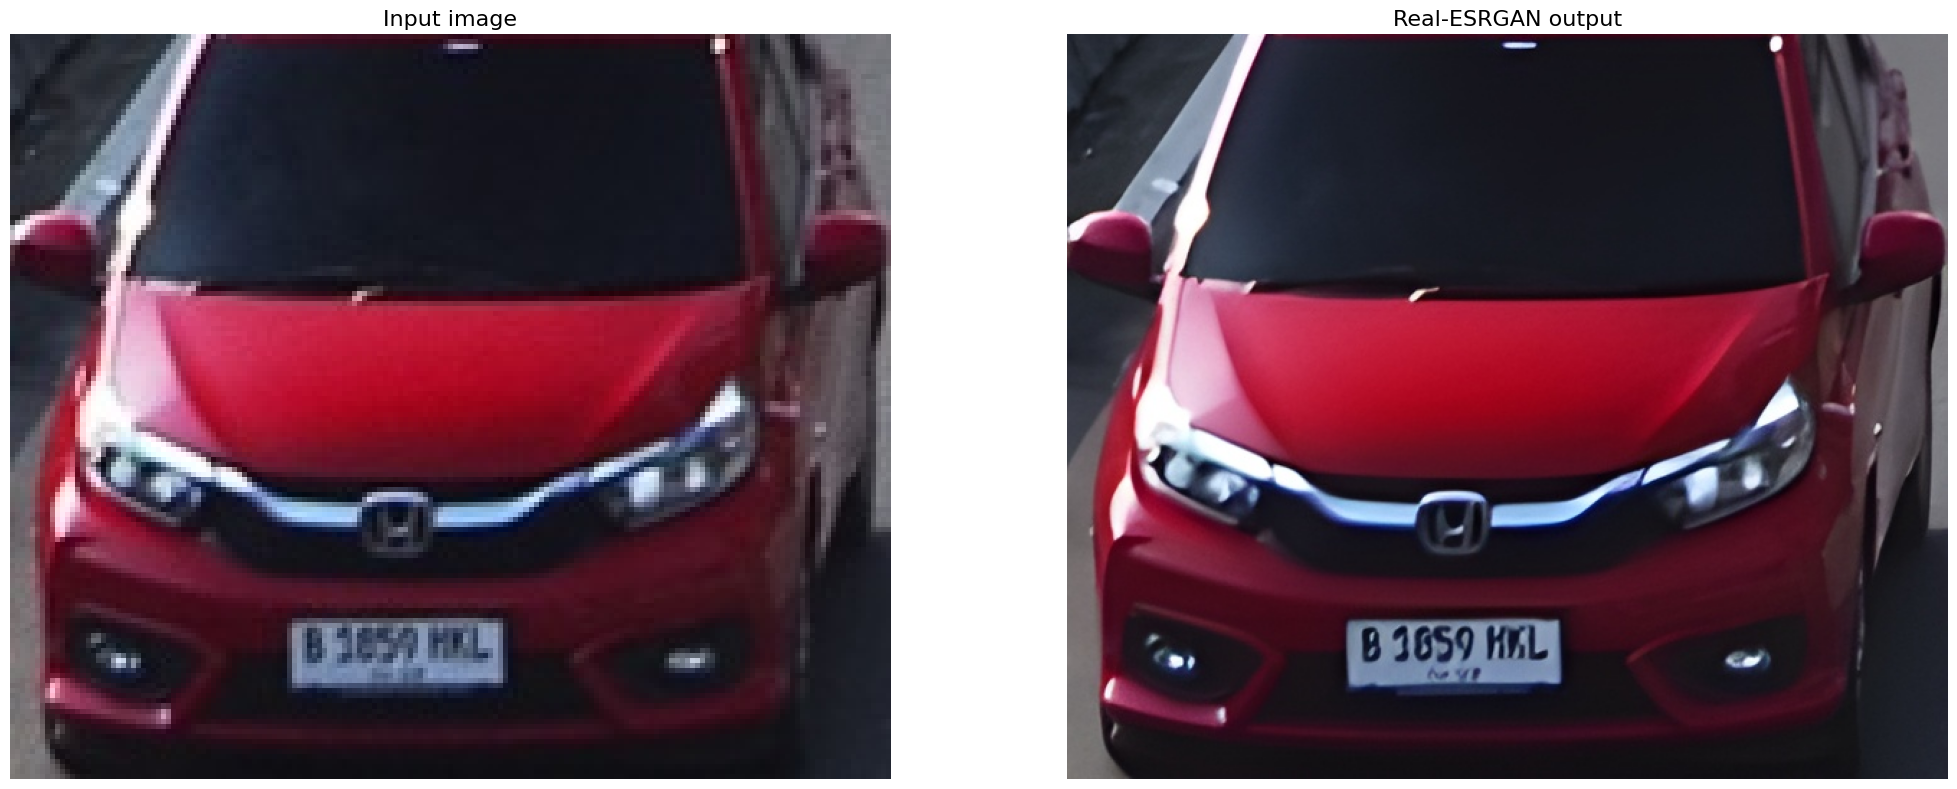

In [ ]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Real-ESRGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'upload'
result_folder = 'results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

# Start to read the plate

I use easyocr to read every text in the picture

In [ ]:
!pip install opencv-python pytesseract easyocr

In [ ]:
import os
import cv2

# Path ke folder Clear Images
folder_path = '/content/drive/MyDrive/Comvi/ANPR/Folder Percobaan/Clear Images/6.TL.Wahidin'

# Fungsi untuk mendeteksi plat nomor
def detect_license_plate(image_path):
    """
    Deteksi plat nomor berdasarkan kontur persegi panjang.
    """
    image = cv2.imread(image_path)
    if image is None:
        return False

    # Konversi ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Penggunaan GaussianBlur untuk mengurangi noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection menggunakan Canny
    edges = cv2.Canny(blurred, 100, 200)

    # Temukan kontur
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter kontur yang menyerupai plat nomor (persegi panjang)
    for contour in contours:
        # Approximate kontur ke bentuk poligon
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

        # Cek jika poligon memiliki 4 sisi
        if len(approx) == 4:
            # Hitung rasio aspek (width / height)
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / h
            if 2.0 < aspect_ratio < 5.0:  # Rasio khas plat nomor
                return True

    return False

# Daftar semua file dalam folder
files = os.listdir(folder_path)

# Filter file gambar
image_files = [f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# Hitung jumlah gambar dengan plat nomor terdeteksi
count_detected = 0

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    if detect_license_plate(image_path):
        count_detected += 1

print(f"Jumlah gambar dengan plat nomor terdeteksi: {count_detected}")


Jumlah gambar dengan plat nomor terdeteksi: 392


In [ ]:
import os
import cv2
import easyocr
import matplotlib.pyplot as plt

# Fungsi untuk membaca dan menandai plat nomor pada gambar
def detect_and_save_text(input_folder, output_folder):
    # Inisialisasi EasyOCR reader
    reader = easyocr.Reader(['id'], gpu=False)
    threshold = 0.25  # Confidence threshold

    # Loop melalui semua subfolder dan file dalam folder input
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter file gambar
                input_path = os.path.join(root, file)
                output_subfolder = os.path.relpath(root, input_folder)
                output_folder_path = os.path.join(output_folder, output_subfolder)

                # Membaca gambar
                img = cv2.imread(input_path)
                if img is None:
                    print(f"Gagal membaca gambar: {input_path}")
                    continue

                # Deteksi teks pada gambar
                text_results = reader.readtext(img)

                # Tandai bounding box dan teks pada gambar
                for bbox, text, score in text_results:
                    if score > threshold:
                        # Gambarkan bounding box
                        cv2.rectangle(img, tuple(map(int, bbox[0])), tuple(map(int, bbox[2])), (0, 255, 0), 2)
                        # Tambahkan teks di atas bounding box
                        cv2.putText(
                            img, text, tuple(map(int, bbox[0])), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255, 0, 0), 2
                        )

                # Buat folder output jika belum ada
                os.makedirs(output_folder_path, exist_ok=True)

                # Simpan gambar hasil ke folder output
                output_file_path = os.path.join(output_folder_path, file)
                cv2.imwrite(output_file_path, img)
                print(f"Plat nomor ditandai dan disimpan: {output_file_path}")

# Path folder input dan output
input_folder = '/content/drive/MyDrive/Comvi/ANPR/Clear Images/6.TL.Wahidin'
output_folder = '/content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin'

# Jalankan fungsi
detect_and_save_text(input_folder, output_folder)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompletePlat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./1-bus_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./1-car(2)_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./1-car_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./10-car(2)_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./10-car_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./10-motorcycle(2)_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./10-motorcycle(4)_out.jpg
Plat nomor ditandai dan disimpan: /content/drive/MyDrive/Comvi/ANPR/Detected Images/6.TL.Wahidin/./10

In [ ]:
import os

# Define the path
path = "/content/drive/MyDrive/Comvi/ANPR/Folder Percobaan/Detected Images"

# Loop through each subfolder and count files
for root, dirs, files in os.walk(path):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"Folder: {dir_name}, Jumlah file: {file_count}")

Folder: 6.TL.Wahidin, Jumlah file: 466
